In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import csv
import os.path
import datetime
from cycler import cycler
import pandas as pd

In [2]:
# Class object for information about series (E.g. "CUDA memcpy HtoD Pageble Device")
# Name and index are defined on an instance creation (in __init__ function),
# timestamp and value are filled later.
class extDataFrame(pd.DataFrame):
    name = ""
    subplot = 1 # subplot number
    
    def __init__(self, name, columns, subplot = 1):
        self.name = name
        self.subplot = subplot
        super(extDataFrame,self).__init__(columns=columns)
        
    def __str__(self):
        s = "DataFrame "+self.name+"\n"
        s = s+ super(extDataFrame,self).__str__()+"\n"
        return s

# Search dataframes list.
# Returns existing element if name is found,
# a new element appended to the list otherwise.
def getDataframe(name, subplot = 1):
    global dataframes
    for df in dataframes:
        if df.name == name:
            return df
    df_n = extDataFrame(name,["Throughput"],subplot = subplot)
    dataframes.append(df_n)
    return df_n

In [3]:
trace_dir = "Tensorflow-HP"
filename1 = "nvidia-smi-tfhp.csv"
filename2 = "nvprof-trace-tfhp.csv"
# trace_dir = "HPCG"
# filename1 = "nvidia-smi-hpcg.csv"
# filename2 = "nvprof-trace-hpcg.csv"

img_name = trace_dir+".pdf"

maxrows = 10000
subplots = 6
file1 = os.path.join(trace_dir,filename1)
file2 = os.path.join(trace_dir,filename2)

In [4]:
filename = file2
print "Reading",filename
title_pattern = re.compile("^(Start|s).*")
cuda_pattern = re.compile("\[CUDA .*\]")
# Column indexes
# nvprof trace file
name_field_index = 18
time_field_index = 0
duration_field_index = 1
SSMem_field_index = 9
DSMem_field_index = 10
size_field_index = 11
throughput_field_index = 12
src_field_index = 13
dst_field_index = 14
context_index = 16
stream_index = 17


Reading Tensorflow-HP/nvprof-trace-tfhp.csv


In [5]:
dataframes = [] # Array of DataFrames class instances
rowcounter = 1
with open(filename, "rb") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if rowcounter > maxrows:
            break

        if len(line) > 3:
            if title_pattern.search(line[0]) is None:
                if cuda_pattern.search(line[name_field_index]) is not None:
                    name = line[name_field_index]+" "+line[src_field_index] +line[dst_field_index]
                    name = name.replace("CUDA memcpy ","")
                    name = name.replace("CUDA ","")
                    subplot = 1
                    if line[name_field_index].find("DtoD") > 0 or line[name_field_index].find("memset") > 0:
                        subplot = 2
                    df = getDataframe(name, subplot = subplot)
                    start = pd.to_datetime(line[0], unit='s')
                    df.loc[start] = float(line[throughput_field_index])
                    
        rowcounter += 1
    csvfile.close()

In [6]:
print "nvprof array length", len(dataframes)
print "dataframes:"
for df in dataframes:
    print df.name,df.shape

nvprof array length 5
dataframes:
[memset] Device (566, 1)
[HtoD] PinnedDevice (309, 1)
[DtoD] DeviceDevice (283, 1)
[HtoD] PageableDevice (2, 1)
[DtoH] DevicePinned (29, 1)


In [7]:
# Concatenate array of dataframes into one dataframe
dataframe = []
dataframe = dataframes[0]['Throughput']
max_ =  dataframe.max()
column_names = [dataframes[0].name + " "+ str(max_)]
for df in dataframes[1:]:
    print df['Throughput'].max()
    max_ = df['Throughput'].max()
    column_names.append(df.name + " "+ str(max_))
    df = df['Throughput']
    
    dataframe = pd.concat([dataframe,df], axis=1)

dataframe.columns = column_names

2.457923
47.609326
0.05174
0.005725


In [8]:
plt.rcParams['figure.figsize'] = 20,15

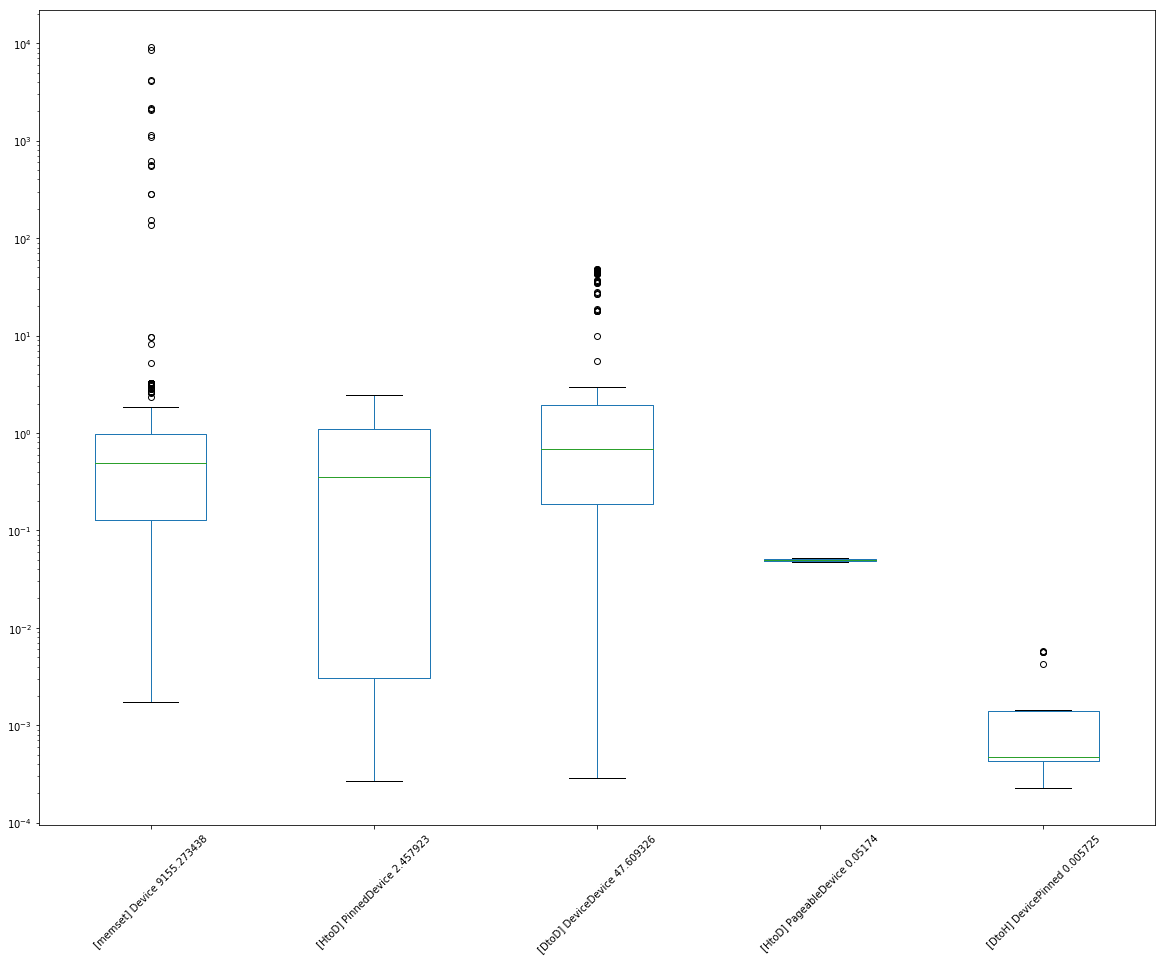

In [9]:
dataframe.plot.box(logy=True,rot=45)

/usr/local/lib/python2.7/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


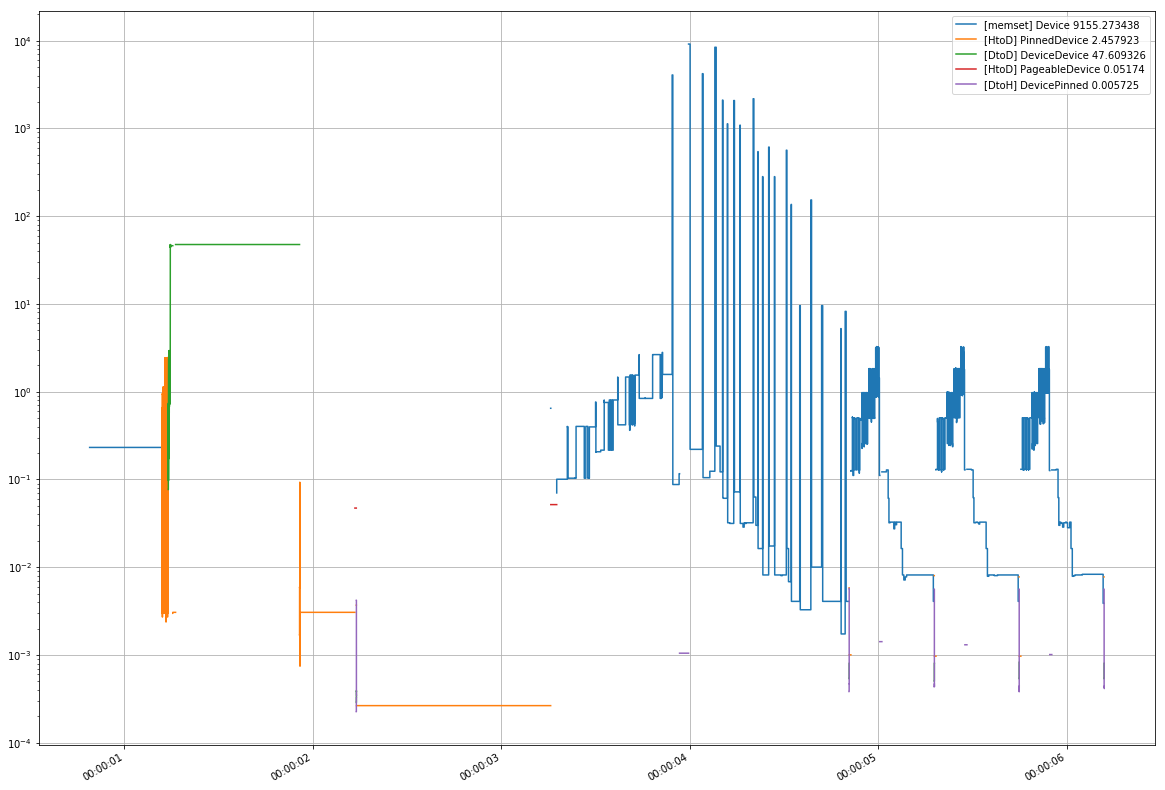

In [10]:
dataframe.plot(drawstyle="steps-post",logy=True,grid=True)

(12, 1)
(11, 1)
(11, 1)
(3, 1)
(9, 1)


No handlers could be found for logger "matplotlib.legend"


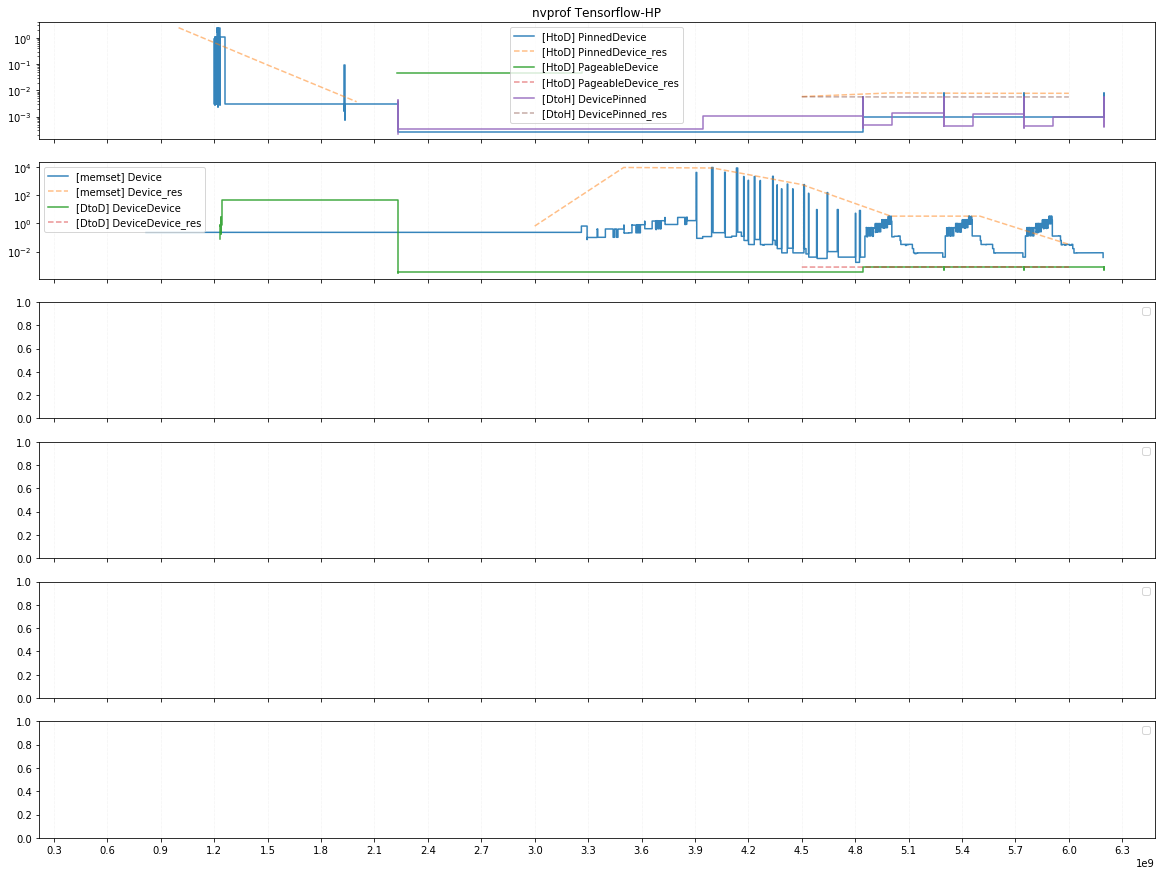

In [11]:
#print dataframes

fig, axarr = plt.subplots(subplots,sharex=True)
#fig.subplots_adjust(hspace=0)
axarr[0].set_title("nvprof "+trace_dir)

#print dataframes[0]
for df in dataframes:
    axis = axarr[df.subplot-1]
    x = np.array(df.index, dtype = float)
    y = np.array(df.loc[:,'Throughput'], dtype = float)
    #print x,y
    axis.plot(x,y,alpha=0.9,label=df.name,drawstyle="steps-post")
    
    resampled = df.resample("500ms").max()
    print resampled.shape
    #axis = axarr[df.subplot-1+2]
    #print resampled
    x = np.array(resampled.index, dtype = float)
    y = np.array(resampled.iloc[:,0], dtype = float)
    #print x,y
    axis.plot(x,y,alpha=0.5,label=df.name+"_res",linestyle="--")
    

for axis in axarr:
    axis.legend()
    axis.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    axis.xaxis.set_major_locator(plt.MaxNLocator(24))
axarr[0].set_yscale('log')
axarr[1].set_yscale('log')
plt.show()

In [ ]:
resampled = dataframe.resample("200ms").max()
resampled = resampled.fillna(0)
#print resampled

In [ ]:
fig, ax = plt.subplots()
x = np.array(resampled.index, dtype = float)
print x.shape
y = np.array(resampled, dtype = float)
y = y.transpose()
print y.shape
ax.stackplot(x,y,labels = resampled.columns)
ax.set_yscale('log')
ax.legend()
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
plt.show()

In [ ]:
resampled.plot.bar(stacked=True,logy=True)
ax = plt.gca()
ax.yaxis.grid(True)